In [17]:
from notebooks.imports import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup


In [2]:
print(PreProcess)

<class 'src.features.preprocess.PreProcess'>


In [3]:
#config

subreddit = "computerscience"

In [4]:
world_posts = pd.read_csv('../data/raw/{}_posts.csv'.format(subreddit))
world_comments = pd.read_csv('../data/raw/{}_comments.csv'.format(subreddit))

# 1. Preprocess

In [5]:
def preprocess(df, col):
    preprocessor = PreProcess()
    preprocessor.fill_na(df, col)
    preprocessor.remove_urls(df, col)
    preprocessor.expand_contractions(df, col)
    preprocessor.remove_escape_chars(df, col)
    return df

### Posts

In [6]:
world_posts.head()

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created
0,n2n0ax,New to programming or computer science? Want a...,375,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1037,The previous thread was finally archived with ...,1.619890e+09
1,qb4bof,THIS IS NOT A TECH SUPPORT SUB OR A COMPUTER R...,404,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,54,Tech Support: /r/techsupport\n\nComputer Recom...,1.634619e+09
2,s8afrp,Ways to learn higher level math through CS?,12,0.88,computerscience,https://www.reddit.com/r/computerscience/comme...,3,"I'm a university student, and while I've taken...",1.642654e+09
3,s7yrsa,Why is there nothing between 8bit and 16bit?,23,0.82,computerscience,https://www.reddit.com/r/computerscience/comme...,19,"For example, if i want to change the image spe...",1.642622e+09
4,s7li8v,Why is Internet/transmission speed in Bit and ...,59,0.95,computerscience,https://www.reddit.com/r/computerscience/comme...,41,I am always wondering about this. Why Internet...,1.642581e+09


In [7]:
posts_df = world_posts.drop(columns=["subreddit", "url","title", "created"])
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body
0,n2n0ax,375,1.00,1037,The previous thread was finally archived with ...
1,qb4bof,404,0.97,54,Tech Support: /r/techsupport\n\nComputer Recom...
2,s8afrp,12,0.88,3,"I'm a university student, and while I've taken..."
3,s7yrsa,23,0.82,19,"For example, if i want to change the image spe..."
4,s7li8v,59,0.95,41,I am always wondering about this. Why Internet...


In [8]:
# posts_pre_df = PreProcess.preprocess(posts_df, 'body')
# for i in range(len(posts_df.index)):
#     posts_pre_df.at[i, 'body_string'] = ' '.join([str(elem) for elem in posts_pre_df.at[i, 'body_stem']])
# posts_pre_df.head()

In [9]:
preprocess(posts_df, "body")

,post_id,score,upvote_ratio,num_comments,body
0,n2n0ax,375,1.00,1037,The previous thread was finally archived with ...
1,qb4bof,404,0.97,54,Tech Support: /r/techsupportComputer Recommend...
2,s8afrp,12,0.88,3,"I am a university student, and while I have ta..."
3,s7yrsa,23,0.82,19,"For example, if i want to change the image spe..."
4,s7li8v,59,0.95,41,I am always wondering about this. Why Internet...
...,...,...,...,...,...
487,q0ta23,1,1.00,1,
488,pr5s8k,477,0.90,98,I hear lots of people think that Computer Scie...
489,oyunkm,997,0.99,82,
490,nxaitf,122,0.94,43,


### Comments

In [10]:
comments_df = world_comments.copy()
comments_df.head()

,post_id,comment
0,n2n0ax,How late is too late to start a career in prog...
1,n2n0ax,I am a freshman at a university and haven't be...
2,n2n0ax,I'm still in highschool but really interested ...
3,n2n0ax,"This is probably a common question, but how we..."
4,n2n0ax,I am planning on starting a CS major this fall...


In [11]:
preprocess(comments_df, "comment")

,post_id,comment
0,n2n0ax,How late is too late to start a career in prog...
1,n2n0ax,I am a freshman at a university and have not b...
2,n2n0ax,I am still in highschool but really interested...
3,n2n0ax,"This is probably a common question, but how we..."
4,n2n0ax,I am planning on starting a CS major this fall...
...,...,...
3174,myc3u1,Look for Ben Eater on YouTube if you are looki...
3175,myc3u1,"I would recommend ""Structured Computer Organiz..."
3176,myc3u1,"Just to give you a very brief overview, there ..."
3177,myc3u1,Thank you for this amazing list of resources :...


# 2. BERT Sentiment Analysis

In [18]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [19]:
def sentiment_score(post):
    tokens = tokenizer.encode(post, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [20]:
posts_df['sentiment'] = posts_df['body'].apply(lambda x: sentiment_score(x[:512]))
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body,sentiment
0,n2n0ax,375,1.00,1037,The previous thread was finally archived with ...,5
1,qb4bof,404,0.97,54,Tech Support: /r/techsupportComputer Recommend...,2
2,s8afrp,12,0.88,3,"I am a university student, and while I have ta...",2
3,s7yrsa,23,0.82,19,"For example, if i want to change the image spe...",3
4,s7li8v,59,0.95,41,I am always wondering about this. Why Internet...,2


In [22]:
comments_df['sentiment'] = comments_df['comment'].apply(lambda x: sentiment_score(x[:512]))
comments_df.head()

,post_id,comment,sentiment
0,n2n0ax,How late is too late to start a career in prog...,1
1,n2n0ax,I am a freshman at a university and have not b...,3
2,n2n0ax,I am still in highschool but really interested...,4
3,n2n0ax,"This is probably a common question, but how we...",3
4,n2n0ax,I am planning on starting a CS major this fall...,3


# 3. EDA sentiments of Posts and Comments

In [25]:
posts_df.corr()

,score,upvote_ratio,num_comments,sentiment
score,1.000000,0.251304,0.270162,0.125229
upvote_ratio,0.251304,1.000000,0.116940,0.115457
num_comments,0.270162,0.116940,1.000000,0.060817
sentiment,0.125229,0.115457,0.060817,1.000000


1     61
2     92
3    142
4    167
5     30
Name: sentiment, dtype: int64


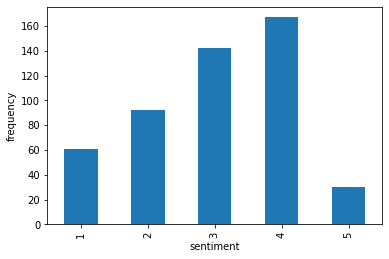

In [37]:
posts_df.sentiment.value_counts().loc[[1, 2, 3, 4, 5]].plot(kind='bar', xlabel='sentiment', ylabel='frequency')
pprint(posts_df.sentiment.value_counts().loc[[1, 2, 3, 4, 5]])
plt.show()

In [52]:
temp_id = posts_df.post_id[0]
print("Looking at one post with id:",temp_id)
posts_df.head(1)

Looking at one post with id: n2n0ax


,post_id,score,upvote_ratio,num_comments,body,sentiment
0,n2n0ax,375,1.0,1037,The previous thread was finally archived with ...,5


In [56]:
median_sentiment_list=[]
for i in posts_df.post_id:
    median_sentiment_list.append(np.median(comments_df[comments_df.post_id==i].sentiment))
posts_df['median_comments_sentiment'] = median_sentiment_list

/Users/saimuktevi/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saimuktevi/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [58]:
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body,sentiment,median_comments_sentiment
0,n2n0ax,375,1.00,1037,The previous thread was finally archived with ...,5,3.0
1,qb4bof,404,0.97,54,Tech Support: /r/techsupportComputer Recommend...,2,3.0
2,s8afrp,12,0.88,3,"I am a university student, and while I have ta...",2,2.0
3,s7yrsa,23,0.82,19,"For example, if i want to change the image spe...",3,2.5
4,s7li8v,59,0.95,41,I am always wondering about this. Why Internet...,2,3.0


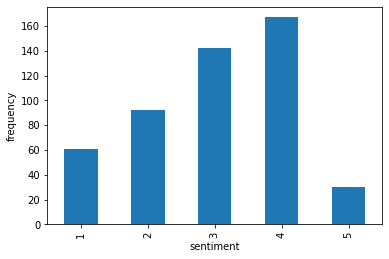

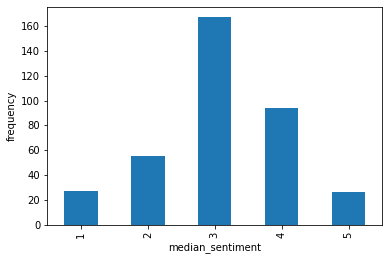

In [63]:
posts_df.sentiment.value_counts().loc[[1, 2, 3, 4, 5]].plot(kind='bar', xlabel='sentiment', ylabel='frequency')
plt.show()
posts_df.median_comments_sentiment.value_counts().loc[[1, 2, 3, 4, 5]].plot(kind='bar', xlabel='median_sentiment', ylabel='frequency')
plt.show()

# 4. Observing with post Metadata

In [93]:
df = posts_df[['post_id','score','upvote_ratio','num_comments', 'sentiment']]
df

,post_id,score,upvote_ratio,num_comments,sentiment
0,n2n0ax,375,1.00,1037,5
1,qb4bof,404,0.97,54,2
2,s8afrp,12,0.88,3,2
3,s7yrsa,23,0.82,19,3
4,s7li8v,59,0.95,41,2
...,...,...,...,...,...
487,q0ta23,1,1.00,1,4
488,pr5s8k,477,0.90,98,2
489,oyunkm,997,0.99,82,4
490,nxaitf,122,0.94,43,4


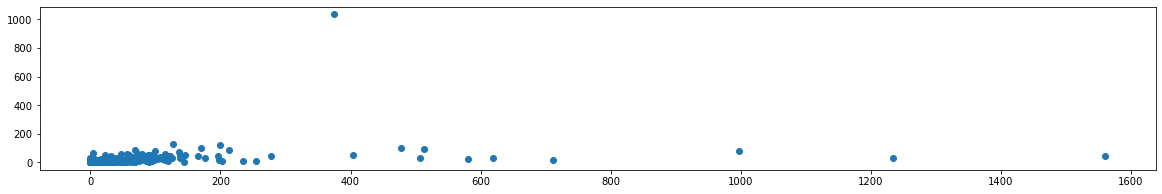

In [104]:
plt.rcParams["figure.figsize"] = (20,3)

plt.scatter(df.score, df.num_comments)
plt.show()

In [90]:
from sklearn.preprocessing import MinMaxScaler
df = posts_df[['post_id','score','upvote_ratio','num_comments', 'sentiment']]
sc = MinMaxScaler()
df = sc.fit_transform(df[['score','upvote_ratio','num_comments']])
df

array([[0.24038462, 1.        , 1.        ],
       [0.25897436, 0.96470588, 0.05207329],
       [0.00769231, 0.85882353, 0.00289296],
       ...,
       [0.63910256, 0.98823529, 0.07907425],
       [0.07820513, 0.92941176, 0.04146577],
       [0.06346154, 0.96470588, 0.02025072]])

In [91]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

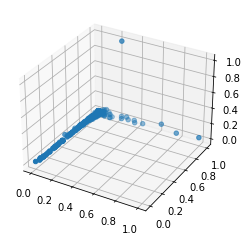

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df['score'], df['upvote_ratio'], df['num_comments'], c=df['sentiment'])
ax.scatter(df[:, 0], df[:, 1], df[:, 2])
plt.show()

In [23]:
#also try with another subreddit

# 5. Fine-Tuning BERT Sentiment Analysis for our Case